Loaded 13233 images from 5749 classes.
Epoch 1/25
662/662 [==============================] - 145s 215ms/step - loss: 6.8509 - accuracy: 0.2312 - val_loss: 6.0368 - val_accuracy: 0.2943 - lr: 1.0000e-04
Epoch 2/25
662/662 [==============================] - 152s 230ms/step - loss: 4.8460 - accuracy: 0.3632 - val_loss: 5.9017 - val_accuracy: 0.3102 - lr: 1.0000e-04
Epoch 3/25
662/662 [==============================] - 154s 233ms/step - loss: 3.9990 - accuracy: 0.4507 - val_loss: 5.6729 - val_accuracy: 0.3442 - lr: 1.0000e-04
Epoch 4/25
662/662 [==============================] - 147s 222ms/step - loss: 3.4228 - accuracy: 0.5283 - val_loss: 5.6469 - val_accuracy: 0.3427 - lr: 1.0000e-04
Epoch 5/25
662/662 [==============================] - 135s 204ms/step - loss: 3.0579 - accuracy: 0.5831 - val_loss: 5.6131 - val_accuracy: 0.3593 - lr: 1.0000e-04
Epoch 6/25
662/662 [==============================] - 159s 240ms/step - loss: 2.7239 - accuracy: 0.6346 - val_loss: 5.5034 - val_accuracy: 0.3619 

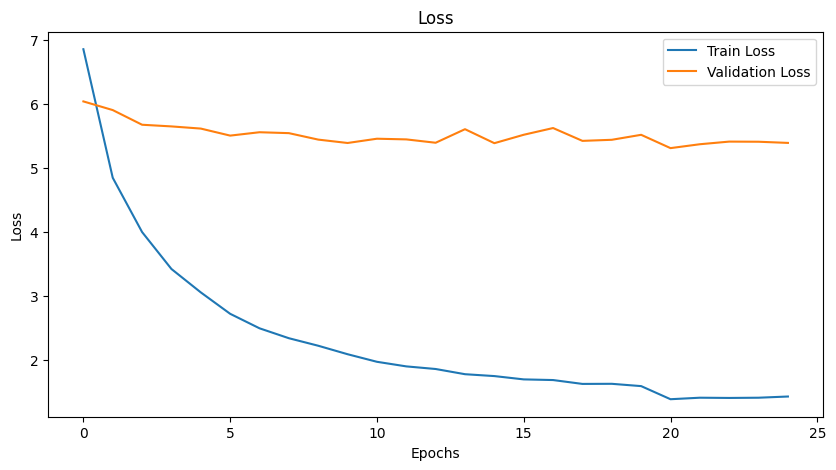

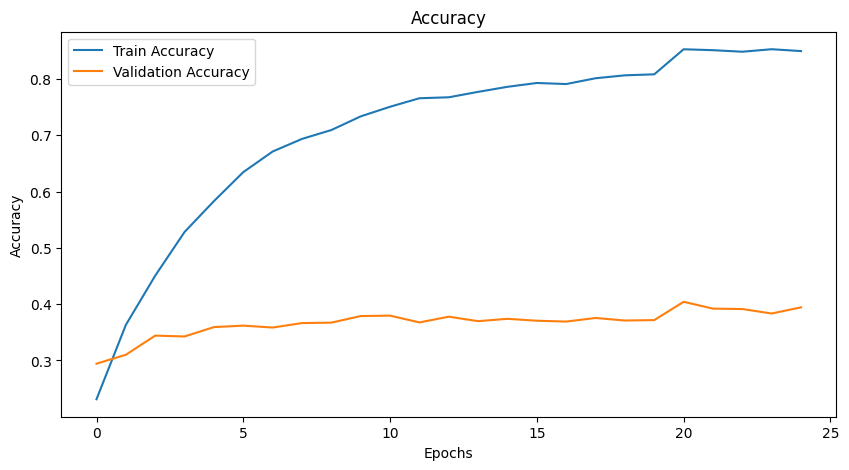

In [3]:
import os
import numpy as np
import tensorflow as tf
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Enable GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print("Error enabling GPU memory growth:", e)

# Dataset loading function
def load_dataset(data_dir, target_size=(224, 224), subset_size=None):
    images, labels, class_names = [], [], []
    for idx, person_name in enumerate(os.listdir(data_dir)):
        person_dir = os.path.join(data_dir, person_name)
        if not os.path.isdir(person_dir):
            continue
        class_names.append(person_name)
        for img_name in os.listdir(person_dir):
            img_path = os.path.join(person_dir, img_name)
            if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
            try:
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                img_array = preprocess_input(img_array, version=1)  # Preprocessing: version=1 as per the repo
                images.append(img_array)
                labels.append(idx)
                if subset_size and len(images) >= subset_size:
                    break
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
        if subset_size and len(images) >= subset_size:
            break
    return np.array(images), np.array(labels), class_names

# Paths
data_dir = r'C:\Users\Alpha\Desktop\Project in secure ML\dataset\lfw-deepfunneled\lfw-deepfunneled'

# Load dataset
images, labels, class_names = load_dataset(data_dir)
print(f"Loaded {len(images)} images from {len(class_names)} classes.")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(class_names))
y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(class_names))

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
train_gen = datagen.flow(X_train, y_train, batch_size=16)
test_gen = datagen.flow(X_test, y_test, batch_size=16)

# Load pre-trained VGGFace model (include_top=True)
image_input = Input(shape=(224, 224, 3))
vggface_model = VGGFace(input_tensor=image_input, include_top=True, weights='vggface')

# Use 'fc8' as the output layer and add a custom dense layer
last_layer = vggface_model.get_layer('fc8').output
output_layer = Dense(len(class_names), activation='softmax', name='output')(last_layer)

# Build the new model
custom_vgg_model = Model(inputs=image_input, outputs=output_layer)

# Freeze all layers except the custom output layer
for layer in custom_vgg_model.layers[:-2]:  # Freeze up to 'fc8'
    layer.trainable = False

# Compile the model
custom_vgg_model.compile(
    optimizer=RMSprop(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Learning rate scheduler and early stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)

# Train the model
history = custom_vgg_model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=25,
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)

# Evaluate the model
loss, accuracy = custom_vgg_model.evaluate(test_gen, verbose=1)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")

# Plot training and validation metrics
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()
